<a href="https://colab.research.google.com/github/bk735/IMPLEMENTING-GPT-MODEL-FROM-SCRATCH-TO-GENERATE-TEXT/blob/main/mat496_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.5 MB/s eta 0:00:00


In [ ]:
from importlib.metadata import version
import tiktoken
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.6.0+cu124
tiktoken version: 0.9.0


In [ ]:
import os
import urllib.request

file_path_1 = "text_data_1.txt"
url = "https://www.gutenberg.org/cache/epub/1342/pg1342.txt"

if not os.path.exists(file_path_1):
    with urllib.request.urlopen(url) as response:
        text_data_1 = response.read().decode('utf-8')
    with open(file_path_1, "w", encoding="utf-8") as file:
        file.write(text_data_1)
else:
    with open(file_path_1, "r", encoding="utf-8") as file:
        text_data_1 = file.read()


In [ ]:
file_path_2 = "text_data_2.txt"
url = "https://www.gutenberg.org/cache/epub/1400/pg1400.txt"

if not os.path.exists(file_path_2):
    with urllib.request.urlopen(url) as response:
        text_data_2 = response.read().decode('utf-8')
    with open(file_path_2, "w", encoding="utf-8") as file:
        file.write(text_data_2)
else:
    with open(file_path_2, "r", encoding="utf-8") as file:
        text_data_2 = file.read()

In [ ]:
dataset = text_data_1 + text_data_2
assert(len(dataset) == len(text_data_1) + len(text_data_2))

In [ ]:
with open("final_dataset.txt", "w", encoding = "utf-8") as file_1:
    file_1.write(dataset)

In [ ]:
with open("final_dataset.txt", "r", encoding = "utf-8") as data:
  data = data.read()

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")
total_characters = len(data)
total_tokens = len(tokenizer.encode(data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 1762018
Tokens: 480074


In [ ]:
GPT_CONFIG_124M = {
    #the number of unique tokens that the model can recognize and generate.
    "vocabulary_size": 50257,

    #the maximum number of tokens the model can process in a single forward pass.
    "context_length": 1024,

    #the size of the vector space used to represent each token.
    "embd_dimension": 768,

    #the number of attention heads in each transformer layer.
    "n_heads": 12,

    #the number of transformer layers stacked on top of each other.
    "n_layers": 12,

    #the probability of randomly disabling neurons during training.
    "dropout_rate": 0.1,

    #indicates whether bias terms are included in the query, key, and value projections of the attention mechanism.
    "qkv_bias": False
}

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
import torch.nn as nn

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [ ]:
#defines GELU function class
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [ ]:
#defines feedforward as class
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["embd_dimension"], 4 * cfg["embd_dimension"]),
            GELU(),
            nn.Linear(4 * cfg["embd_dimension"], cfg["embd_dimension"]),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
import torch.nn as nn

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))
    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["embd_dimension"],
            d_out=cfg["embd_dimension"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["dropout_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["embd_dimension"])
        self.norm2 = LayerNorm(cfg["embd_dimension"])
        self.drop_shortcut = nn.Dropout(cfg["dropout_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocabulary_size"], cfg["embd_dimension"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["embd_dimension"])
        self.drop_emb = nn.Dropout(cfg["dropout_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["embd_dimension"])
        self.out_head = nn.Linear(
            cfg["embd_dimension"], cfg["vocabulary_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [ ]:
def generate_text(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [ ]:
import torch.nn as nn
import torch
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
model = GPTModel(GPT_CONFIG_124M)
model.eval()
out = generate_text(
     model=model,
     idx=encoded_tensor,
     max_new_tokens=6,
     context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 36411, 15645, 33738, 44060, 21533, 15265]])
Output length: 10


In [ ]:
import tiktoken
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you vote spew phosph 37xi meth GravesRussell pumpedGrey


In [ ]:
raw_text = data
total_characters = len(raw_text)
total_tokens = len(tokenizer.encode(raw_text))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 1762018
Tokens: 480074


In [ ]:
#using 90% data as training set and 10% as testing set
train_ratio = 0.90
#calculate the index where you will be splitting your data
split_idx = int(train_ratio * len(data))
train_data = data[:split_idx]
val_data = data[split_idx:]

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):
     def __init__(self, txt, tokenizer, max_length, stride):
         self.input_ids = []
         self.target_ids = []

         token_ids = tokenizer.encode(txt)

         for i in range(0, len(token_ids) - max_length, stride):
             input_chunk = token_ids[i:i + max_length]
             target_chunk = token_ids[i + 1: i + max_length + 1]
             self.input_ids.append(torch.tensor(input_chunk))
             self.target_ids.append(torch.tensor(target_chunk))

     def __len__(self):
        return len(self.input_ids)

     def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [ ]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
 )

    return dataloader

In [ ]:
train_loader = create_dataloader_v1(
     train_data,
     batch_size=4,
     max_length=GPT_CONFIG_124M["context_length"],
     stride=GPT_CONFIG_124M["context_length"],
     drop_last=True,
     shuffle=True,
     num_workers=0
)


val_loader = create_dataloader_v1(
     val_data,
     batch_size=4,
     max_length=GPT_CONFIG_124M["context_length"],
     stride=GPT_CONFIG_124M["context_length"],
     drop_last=False,
     shuffle=False,
     num_workers=0
)

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
     input_batch = input_batch.to(device)
     target_batch = target_batch.to(device)
     logits = model(input_batch)
     loss = torch.nn.functional.cross_entropy(
         logits.flatten(0, 1), target_batch.flatten()
     )
     return loss

In [ ]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
     total_loss = 0.
     if len(data_loader) == 0:
         return float("nan")
     elif num_batches is None:
         num_batches = len(data_loader)
     else:
         num_batches = min(num_batches, len(data_loader))
     for i, (input_batch, target_batch) in enumerate(data_loader):
         if i < num_batches:
             loss = calc_loss_batch(
                 input_batch, target_batch, model, device
             )
             total_loss += loss.item()
         else:
             break
     return total_loss / num_batches

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 11.01148034050351
Validation loss: 11.00675638516744


In [ ]:
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss



In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="The work is mysterious and important", tokenizer=tokenizer
)


Ep 1 (Step 000000): Train loss 10.838, Val loss 10.854
Ep 1 (Step 000005): Train loss 10.119, Val loss 10.154
Ep 1 (Step 000010): Train loss 9.610, Val loss 9.598
Ep 1 (Step 000015): Train loss 9.258, Val loss 9.278
Ep 1 (Step 000020): Train loss 9.087, Val loss 9.070
Ep 1 (Step 000025): Train loss 8.922, Val loss 8.911
Ep 1 (Step 000030): Train loss 8.740, Val loss 8.786
Ep 1 (Step 000035): Train loss 8.652, Val loss 8.665
Ep 1 (Step 000040): Train loss 8.500, Val loss 8.547
Ep 1 (Step 000045): Train loss 8.448, Val loss 8.437
Ep 1 (Step 000050): Train loss 8.203, Val loss 8.328
Ep 1 (Step 000055): Train loss 8.201, Val loss 8.219
Ep 1 (Step 000060): Train loss 7.985, Val loss 8.113
Ep 1 (Step 000065): Train loss 7.964, Val loss 8.019
Ep 1 (Step 000070): Train loss 7.886, Val loss 7.944
Ep 1 (Step 000075): Train loss 7.823, Val loss 7.880
Ep 1 (Step 000080): Train loss 7.702, Val loss 7.763
Ep 1 (Step 000085): Train loss 7.408, Val loss 7.648
Ep 1 (Step 000090): Train loss 7.555, Val 

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

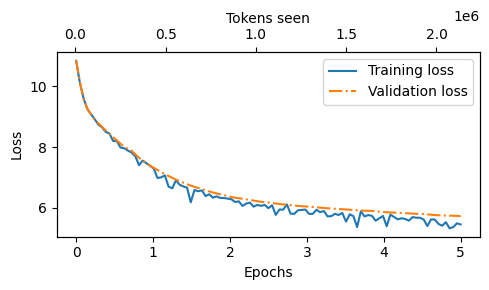

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
def generate_fun(context):
  generate_and_print_sample(model, tokenizer, device, context)


In [ ]:
context = input("Enter first context:")
generate_fun(context)

Enter first context:pride and prejudice is wonderful movie
pride and prejudice is wonderful movie, and    ” ” ” ” ” ” ” ” ” ” ” ” ” ” ”
